# Customer Support RAG Agent

In this guide, you build an **agent** to perform **RAG** and answer questions related to a car manual PDF using [LlamaIndex](https://github.com/run-llama/llama_index), [Redis](https://redis.io), and [Cohere](https://cohere.com/).

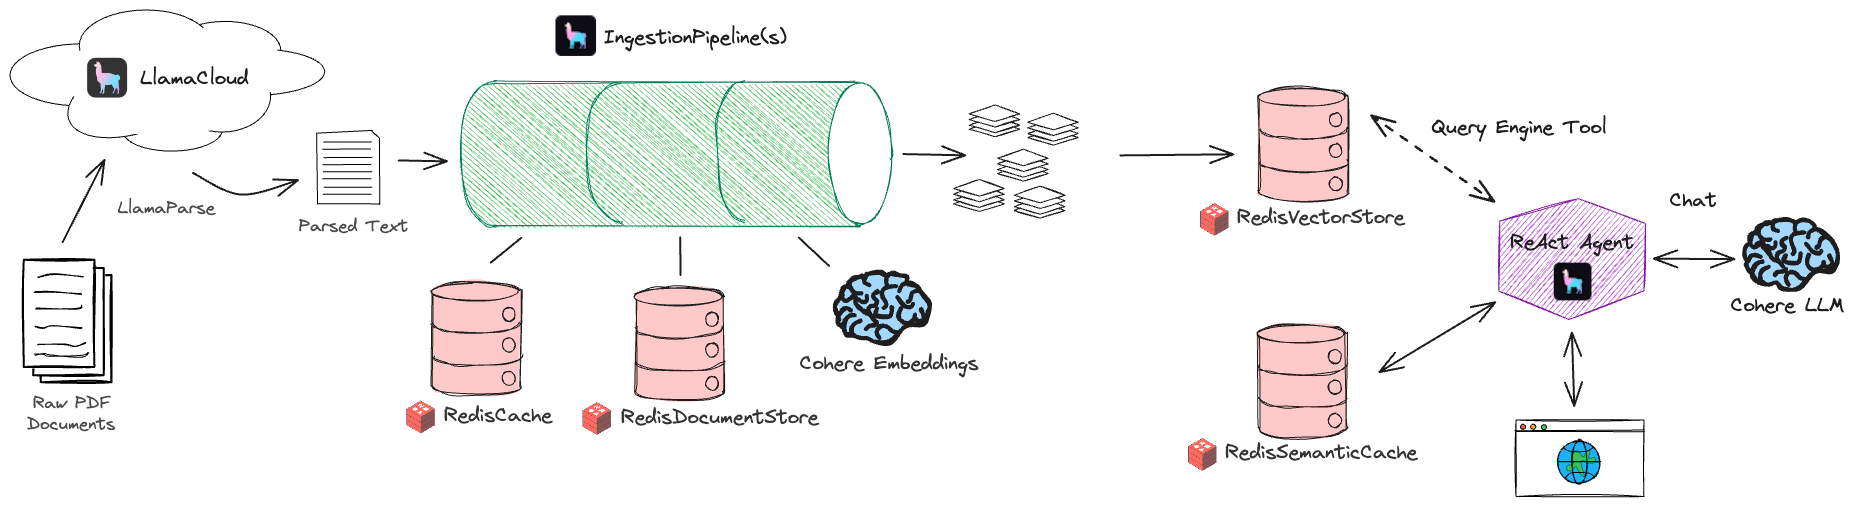

If you're opening this Notebook on colab, you will need to install LlamaIndex 🦙 and a number of related integration dependencies.

In [ ]:
# @title
%pip install -U llama-index llama-parse llama-hub
%pip install llama-index-vector-stores-redis
%pip install llama-index-storage-docstore-redis
%pip install llama-index-storage-chat-store-redis
%pip install llama-index-llms-cohere
%pip install llama-index-embeddings-cohere
%pip install llama-index-embeddings-huggingface

In [ ]:
%load_ext autoreload
%autoreload 2

## Setup and Download Data

In this section, we'll set up a simple Redis db, configure the environment, and ingest the PDF document.

### Setup Redis

In [ ]:
%%sh
curl -fsSL https://packages.redis.io/gpg | sudo gpg --dearmor -o /usr/share/keyrings/redis-archive-keyring.gpg
echo "deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb $(lsb_release -cs) main" | sudo tee /etc/apt/sources.list.d/redis.list
sudo apt-get update  > /dev/null 2>&1
sudo apt-get install redis-stack-server  > /dev/null 2>&1
redis-stack-server --daemonize yes

deb [signed-by=/usr/share/keyrings/redis-archive-keyring.gpg] https://packages.redis.io/deb jammy main
Starting redis-stack-server, database path /var/lib/redis-stack


In [ ]:
REDIS_HOST="localhost"
REDIS_PORT=6379
REDIS_PASSWORD=""

### Environment Configuration
You will need both a LlamaCloud API Key and a Cohere API Key.

In [ ]:
import os

os.environ["LLAMA_CLOUD_API_KEY"] = "YOUR API KEY"
os.environ["CO_API_KEY"] = "YOUR API KEY"

In [ ]:
# need this for running llama-index code in Jupyter Notebooks
import nest_asyncio
nest_asyncio.apply()

### Download, Parse and Ingest Document
First we will download the PDF for this example. We will use a simple bash command to pull the file from a related github project.

In [ ]:
!mkdir -p 'data/'
!wget 'https://raw.githubusercontent.com/redis-developer/LLM-Document-Chat/main/docs/2022-chevrolet-colorado-ebrochure.pdf' -O 'data/2022-chevrolet-colorado-ebrochure.pdf'

--2024-04-16 02:26:52--  https://raw.githubusercontent.com/redis-developer/LLM-Document-Chat/main/docs/2022-chevrolet-colorado-ebrochure.pdf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3566101 (3.4M) [application/octet-stream]
Saving to: ‘data/2022-chevrolet-colorado-ebrochure.pdf’

data/2022-chevrolet 100%[===================>]   3.40M  --.-KB/s    in 0.07s   

2024-04-16 02:26:53 (46.1 MB/s) - ‘data/2022-chevrolet-colorado-ebrochure.pdf’ saved [3566101/3566101]



Using LlamaParse on LlamaCloud, parsing the PDF is done with great precision and accuracy.

In [ ]:
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader

parser = LlamaParse(
    result_type="markdown"  # "markdown" and "text" are available
)

file_extractor = {".pdf": parser}
reader = SimpleDirectoryReader("./data", file_extractor=file_extractor)
documents = reader.load_data()

Started parsing the file under job_id 2c35fd53-fce2-4a41-b2b7-a7a064f6d350


Below we build a custom index schema for the `RedisVectorStore` that uses the cohere embedding model and some custom index specifications.

In [ ]:
from llama_index.embeddings.cohere import CohereEmbedding
from llama_index.core.ingestion import (
    DocstoreStrategy,
    IngestionPipeline,
    IngestionCache,
)
from llama_index.storage.kvstore.redis import RedisKVStore as RedisCache
from llama_index.storage.docstore.redis import RedisDocumentStore
from llama_index.core.node_parser import SentenceSplitter
from llama_index.vector_stores.redis import RedisVectorStore

from redisvl.schema import IndexSchema


embed_model = CohereEmbedding(input_type="search_document")

custom_schema = IndexSchema.from_dict(
    {
        "index": {
            "name": "chevy-colorado",
            "prefix": "pdf:chunk",
            "key_separator": ":"
          },
        # customize fields that are indexed
        "fields": [
            # required fields for llamaindex
            {"type": "tag", "name": "id"},
            {"type": "tag", "name": "doc_id"},
            {"type": "text", "name": "text"},
            # custom vector field for cohere embeddings
            {
                "type": "vector",
                "name": "vector",
                "attrs": {
                    "dims": 1024,
                    "algorithm": "hnsw",
                    "distance_metric": "cosine",
                },
            },
        ],
    }
)

Now we can build an end to end ingestion pipeline as a sequence of transformations backed by a cache, document store, and a sink. **Notice that Redis is used at all stages of the ingest pipeline to process documents at scale, minimizing redundant compute (and thus long-running costs).**

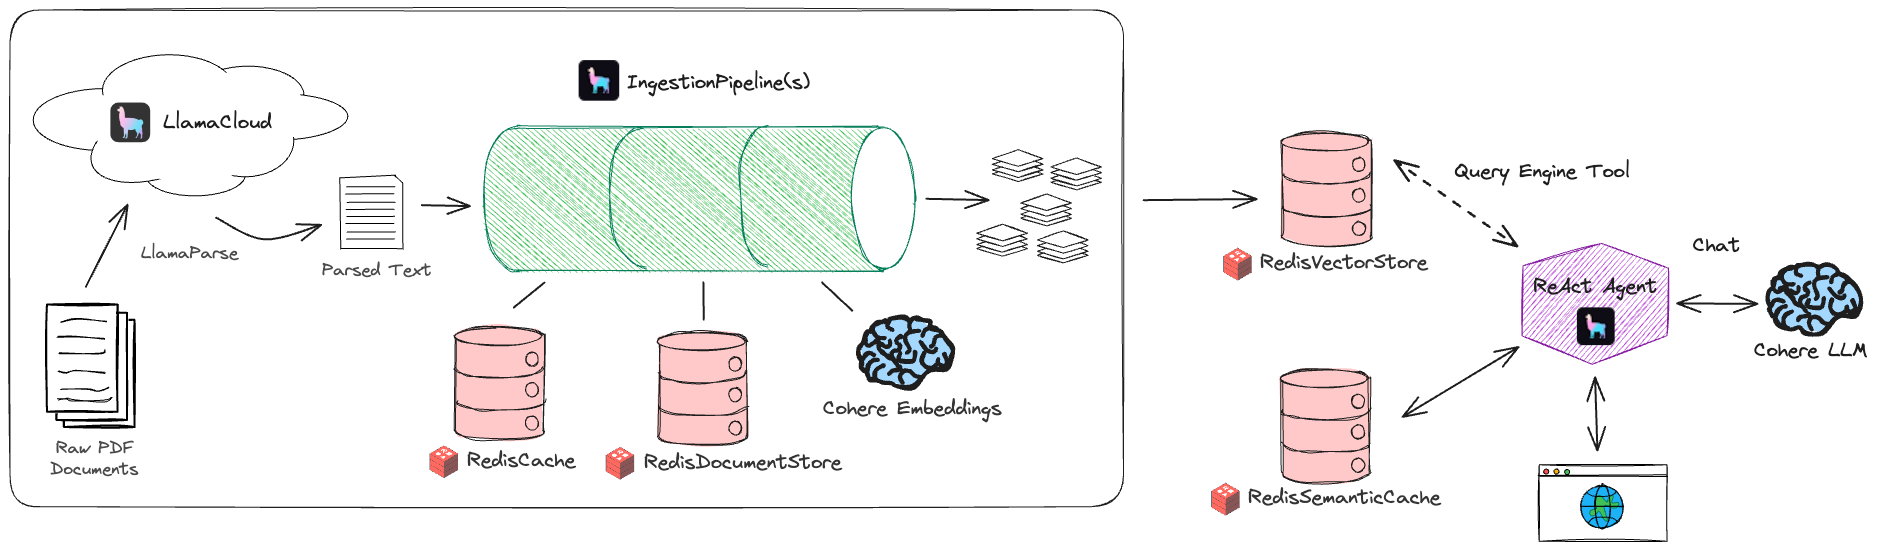

In [ ]:
vector_index_pipeline = IngestionPipeline(
    transformations=[
        SentenceSplitter(),
        embed_model,
    ],
    docstore=RedisDocumentStore.from_host_and_port(
        REDIS_HOST, REDIS_PORT, namespace="doc-store"
    ),
    vector_store=RedisVectorStore(
        schema=custom_schema,
        redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}",
    ),
    cache=IngestionCache(
        cache=RedisCache.from_host_and_port(REDIS_HOST, REDIS_PORT),
        collection="doc-cache",
    ),
    docstore_strategy=DocstoreStrategy.UPSERTS,
)

In [ ]:
vector_index_pipeline.run(documents=documents, show_progress=True)

### Test pipeline consistency and optimizations
Since we are using the document store and cache, we can run the exact same document through, and note that nothing else is ingested because it's already been done. **This helps prevent redundant computation on ETL, improving costs and throughput at scale.**


In [ ]:
vector_index_pipeline.run(documents=documents)

[]

## Building the ReAct Agent

In this section we define a **ReAct** agent that will perform RAG over a PDF document using the Cohere `command-r-plus` language model.

**ReAct** is an agent based on a query engine over your data. For each chat interaction, the agent enter a ReAct loop:

- decide whether to use the query engine tool and come up with appropriate input
- (optional) use the query engine tool and observe its output
- decide whether to repeat or give final response

### Agent Setup

Below we define our LLM, embedding model, and a chat memory layer backed by Redis for conversation history and context.

We define both a vector index (for semantic search) and summary index (for summarization) for the document -- used as tools by the agent.

In [ ]:
# Setup Cohere as the base embedding model and LLM
from llama_index.llms.cohere import Cohere
from llama_index.core import Settings

llm = Cohere(model="command-r-plus")
Settings.llm = llm
Settings.embed_model = CohereEmbedding(input_type="search_query")

In [ ]:
# Set up memory for the Agent
from llama_index.storage.chat_store.redis import RedisChatStore
from llama_index.core.memory import ChatMemoryBuffer

# Build chat memory backed by Redis
chat_memory = ChatMemoryBuffer.from_defaults(
    token_limit=3000,
    chat_store=RedisChatStore(redis_url=f"redis://{REDIS_HOST}:{REDIS_PORT}", ttl=300),
    chat_store_key="user_1"
)

In [ ]:
from llama_index.core.agent import ReActAgent
from llama_index.core import SummaryIndex, VectorStoreIndex
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.node_parser import SentenceSplitter

import pickle


async def build_doc_agent(doc):
    # ID will be base + parent
    file_name = doc.metadata["file_name"]
    file_path = f"./data/{file_name}"
    file_id = file_name.replace("-", "_").strip(".pdf")
    print(file_id)

    # Run ingestion
    vector_index_pipeline.run(documents=[doc], show_progress=True)

    # Grab the nodes
    node_parser = SentenceSplitter()
    nodes = node_parser.get_nodes_from_documents([doc])

    # Define vector index and query engine
    vector_index = VectorStoreIndex.from_vector_store(
        vector_index_pipeline.vector_store
    )
    vector_query_engine = vector_index.as_query_engine()

    # Build summary index and extract a summary
    summary_index = SummaryIndex(nodes)
    summary_query_engine = summary_index.as_query_engine(
        response_mode="tree_summarize"
    )
    summary_out_path = f"./data/{file_name}_summary.pkl"
    summary = str(
        await summary_query_engine.aquery(
            "Extract a concise 1-2 line summary of this document"
        )
    )
    pickle.dump(summary, open(summary_out_path, "wb"))

    # Define agent tools
    query_engine_tools = [
        QueryEngineTool(
            query_engine=vector_query_engine,
            metadata=ToolMetadata(
                name=f"vector_tool_{file_id}",
                description=f"Useful for questions related to specific facts about the chevy colorado",
            ),
        )
    ]

    # Build ReAct agent
    agent = ReActAgent.from_tools(
        query_engine_tools,
        llm=llm,
        verbose=True,
        memory=chat_memory,
        context=f"""\
You are a specialized, trustworthy, helpful, and technical customer support agent designed to answer queries about the Chevy Colorado 2022 vehicle.
Use the available tools provided when answering a question. Do NOT just blindly make things up about the car unless it is grounded by the retrieved sources.\
""")

    return agent, summary


In [ ]:
agent, doc_summary = await build_doc_agent(documents[0])

2022_chevrolet_colorado_ebrochure
02:28:47 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
02:28:47 llama_index.core.agent.react.formatter WARNING   ReActChatFormatter.from_context is deprecated, please use `from_defaults` instead.


In [ ]:
doc_summary

'The 2022 Chevrolet Colorado is a midsize pickup truck with four models, three engine options, and various special editions and packages. It offers a range of features, including different cab and bed sizes, advanced technology, and off-road capabilities.'

## Using the Agent
Below we will use our agent.

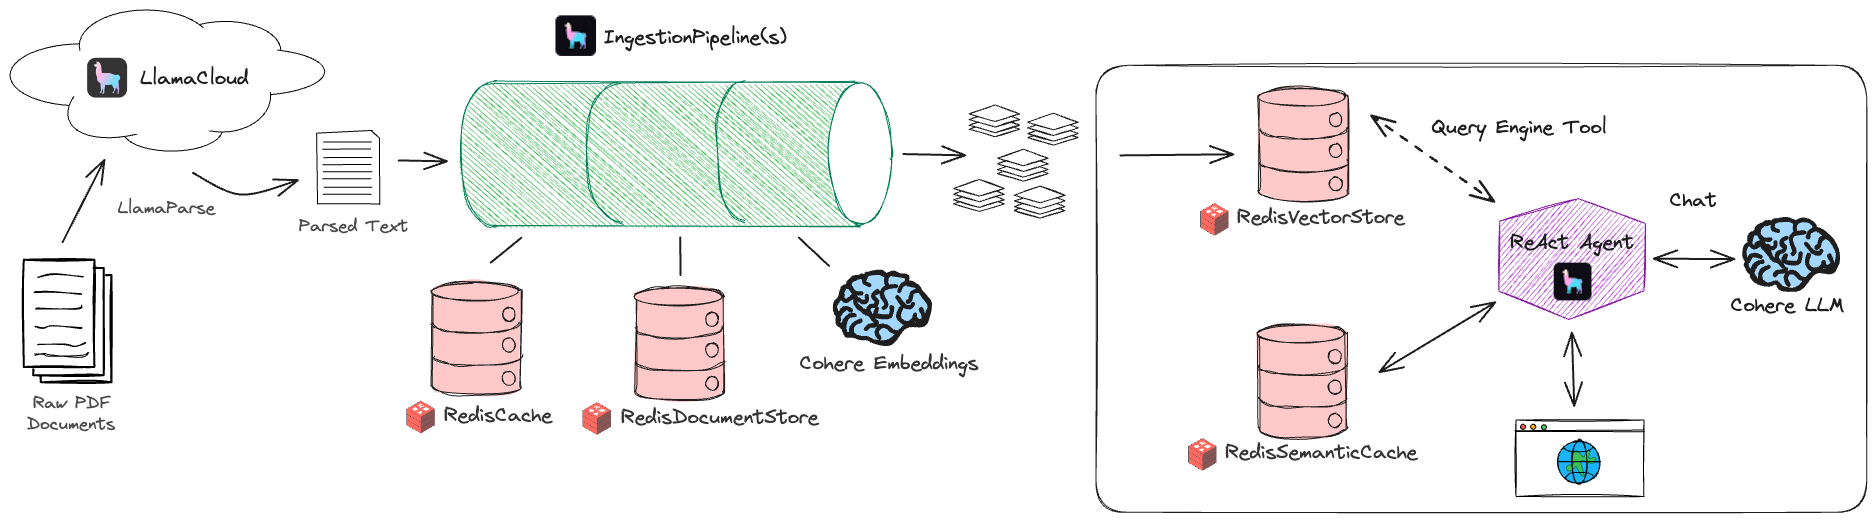



In [ ]:
response = agent.chat("What is the seating capacity of the vehicle?")
print(str(response))

02:29:01 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool_2022_chevrolet_colorado_ebrochure
Action Input: {'input': 'How many people can fit in the car?'}
02:29:01 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/embed "HTTP/1.1 200 OK"
02:29:01 llama_index.vector_stores.redis.base INFO   Querying index chevy-colorado with filters *
02:29:01 llama_index.vector_stores.redis.base INFO   Found 2 results for query with id ['pdf:chunk:2f38b008-f1af-4123-ac14-e24e0cb70a47', 'pdf:chunk:1650d50b-5936-45b4-b1cd-9b855f377ef7']
02:29:02 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Observation: The text does not specify the seating capacity of the car.
02:29:04 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: I cannot answer the question with the provided tool

In [ ]:
response = agent.chat("What is the towing capacity?")
print(str(response))

02:29:07 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool_2022_chevrolet_colorado_ebrochure
Action Input: {'input': 'What is the towing capacity?'}
02:29:07 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/embed "HTTP/1.1 200 OK"
02:29:07 llama_index.vector_stores.redis.base INFO   Querying index chevy-colorado with filters *
02:29:07 llama_index.vector_stores.redis.base INFO   Found 2 results for query with id ['pdf:chunk:444bbb71-04fc-4547-a069-0cadee0ff9b3', 'pdf:chunk:1650d50b-5936-45b4-b1cd-9b855f377ef7']
02:29:10 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Observation: The 2022 Chevrolet Colorado has a maximum trailering/towing capacity of 7,700 lbs when equipped with the available Duramax 2.8L Turbo-Diesel engine. The towing capacity varies based on the configuration and engine c

In [ ]:
response = agent.chat("Is there a trailer hitch on the back of the truck?")
print(str(response))

02:29:17 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool_2022_chevrolet_colorado_ebrochure
Action Input: {'input': 'trailer hitch'}
02:29:17 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/embed "HTTP/1.1 200 OK"
02:29:17 llama_index.vector_stores.redis.base INFO   Querying index chevy-colorado with filters *
02:29:17 llama_index.vector_stores.redis.base INFO   Found 2 results for query with id ['pdf:chunk:fcd08dab-f086-489c-bdab-e1ea5a3794a9', 'pdf:chunk:444bbb71-04fc-4547-a069-0cadee0ff9b3']
02:29:19 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Observation: The trailer hitch is included in the Trailering Package, which is standard on Crew Cab Long Box models. It is also available as an option on other configurations when combined with specific engine and rear differential configurati

In [ ]:
response = agent.chat("Tell me about the pros and cons of this truck.")
print(str(response))

02:29:24 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool_2022_chevrolet_colorado_ebrochure
Action Input: {'input': 'pros and cons'}
02:29:24 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/embed "HTTP/1.1 200 OK"
02:29:24 llama_index.vector_stores.redis.base INFO   Querying index chevy-colorado with filters *
02:29:24 llama_index.vector_stores.redis.base INFO   Found 2 results for query with id ['pdf:chunk:66fa380a-865a-4e7a-a8be-8f54e55c25de', 'pdf:chunk:22cba2f7-df0b-4fcf-b275-a42d66daba7e']
02:29:33 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Observation: **Pros:**
- The 2022 Chevrolet Colorado offers a range of features that enhance its functionality, performance, and comfort.
- It has a variety of safety features, including dual-stage frontal airbags, side-impact airbags, head-cu

In [ ]:
agent.memory.chat_store.get_messages("user_1")

[ChatMessage(role=<MessageRole.USER: 'user'>, content='What is the seating capacity of the vehicle?', additional_kwargs={}),
 ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='Sorry, I could not find the seating capacity of the 2022 Chevrolet Colorado in the provided sources.', additional_kwargs={}),
 ChatMessage(role=<MessageRole.USER: 'user'>, content='What is the towing capacity?', additional_kwargs={}),
 ChatMessage(role=<MessageRole.ASSISTANT: 'assistant'>, content='The towing capacity of the 2022 Chevrolet Colorado varies depending on the configuration and engine choice. When equipped with the available Duramax 2.8L Turbo-Diesel engine, it can achieve a maximum trailering capacity of 7,700 lbs. For example, the Crew Cab Short Box LT with 2WD and the Trailering Package can also tow up to 7,700 lbs, whereas the ZR2 model has a towing capacity of 5,000 lbs.', additional_kwargs={}),
 ChatMessage(role=<MessageRole.USER: 'user'>, content='Is there a trailer hitch on the b

### Incorporating Semantic Caching
We can also take advantage of frequently asked questions (live or prefetched) in order to improve response times.

In [ ]:
from redisvl.extensions.llmcache import SemanticCache
from redisvl.utils.vectorize import HFTextVectorizer

emb = HFTextVectorizer(model="BAAI/bge-small-en-v1.5")

cache = SemanticCache(
    name="chevy_cache",
    prefix="cache",
    distance_threshold=0.2,
    ttl=60,
    vectorizer=emb
)

02:31:30 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: BAAI/bge-small-en-v1.5
02:31:31 sentence_transformers.SentenceTransformer INFO   Use pytorch device_name: cpu


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
def invoke_agent(prompt: str) -> str:
    if cached_result := cache.check(prompt=prompt):
        response = cached_result[0]['response']
        return response
    response = agent.chat(prompt)
    # cache.store(prompt=prompt, response=response.response)
    return response.response

Now we can perform a simple test with our agent and semantic caching enabled.

In [ ]:
invoke_agent("How many doors does the truck have?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

02:31:42 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: vector_tool_2022_chevrolet_colorado_ebrochure
Action Input: {'input': 'How many doors does the truck have?'}
02:31:42 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/embed "HTTP/1.1 200 OK"
02:31:42 llama_index.vector_stores.redis.base INFO   Querying index chevy-colorado with filters *
02:31:42 llama_index.vector_stores.redis.base INFO   Found 2 results for query with id ['pdf:chunk:3fda8d64-8947-45c8-a207-061eb4d6782d', 'pdf:chunk:444bbb71-04fc-4547-a069-0cadee0ff9b3']
02:31:43 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Observation: The truck has four doors.
02:31:44 httpx INFO   HTTP Request: POST https://api.cohere.ai/v1/chat "HTTP/1.1 200 OK"
Thought: I can answer without using any more tools. I'll use the user's language to answer.
A

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'The Chevy Colorado has four doors.'

In [ ]:
invoke_agent("How many passenger doors are on the truck?")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

'The Chevy Colorado has four doors.'

### Extending Semantic Caching


There are a few options for working with semantic caching in a true production setting:
1.   Extract FAQs from your Knowledge Base (pdfs...). Use an LLM to help! Or use human experts. Prefetch into the cache.
2. Carefully, extract FAQs from conversation history. Prefetch in batches into the cache each day or week.
3. Cache in realtime, which is tricky and requires some tuning. This should typically be done only at the USER level, not across the entire domain or application.

**Stay tuned for more dedicated guides on semantic caching for RAG Agents and Redis.**


